In [2]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

In [3]:
RESULTS_FOLDER = "../results"
DATA_FOLDER = "../data"
TEMP_FOLDER = "../tmp"

Normalized Predictions: [5. 2. 5. ... 3. 3. 4.]
train: 0       3
1       1
2       3
3       1
4       6
       ..
5766    5
5767    1
5768    1
5769    2
5770    9
Name: decile_score, Length: 5771, dtype: int64
Mean Squared Error: 5.044879570265119
R-squared Score: 0.37350941834997764
Intercept (w_0): 4.498353838156299
Coefficients (w_1, w_2, ...): [-1.0988714   0.21162846  0.80234679  0.02079777 -0.75142655  0.09758879
 -0.09758879]
                   Feature  Coefficient
0                      age    -1.098871
1             priors_count     0.211628
2      history_of_violence     0.802347
3  days_b_screening_arrest     0.020798
4  socioeconomic_stability    -0.751427
5        c_charge_degree_F     0.097589
6        c_charge_degree_M    -0.097589


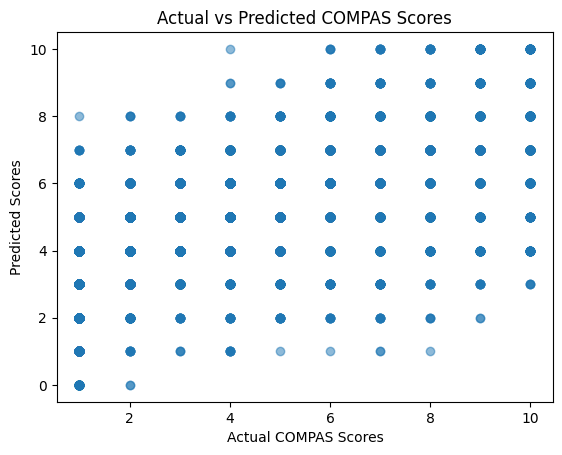

NameError: name 'y_test' is not defined

In [4]:

# Load the dataset (replace 'train_dataset.csv' with your dataset path)
df_train_path = os.path.join(DATA_FOLDER, 'train_dataset.csv')
df_train = pd.read_csv(df_train_path)

# Feature Engineering

# Composite feature for history_of_violence
df_train["history_of_violence"] = (
    df_train["juv_fel_count"] + df_train["juv_misd_count"] + df_train["juv_other_count"] + df_train["priors_count"]
)

# Socioeconomic stability proxy
df_train["socioeconomic_stability"] = (1 / (1 + df_train["priors_count"])) 

# Select relevant features for the COMPAS equation
X_train = df_train[[ 
    "age", "priors_count", "history_of_violence", "days_b_screening_arrest", 
    "socioeconomic_stability", "c_charge_degree_F", "c_charge_degree_M"
]]

y_train_compas = df_train["decile_score"]
y_train = df_train["two_year_recid"] * 10

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_train_scaled)
# Normalize the predicted values to the range [0, 10]
#y_pred_normalized =  10 * (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
#y_pred_normalized = 10 / (1 + np.exp(-y_pred))
y_pred_normalized =  np.clip( np.ceil(y_pred), 0, 10)



print("Normalized Predictions:", y_pred_normalized)
print("train:", y_train_compas) 


# Evaluate the model
mse = mean_squared_error(y_train_compas, y_pred_normalized)
r2 = r2_score(y_train_compas, y_pred_normalized)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Coefficients (interpretable weights)
print("Intercept (w_0):", model.intercept_)
print("Coefficients (w_1, w_2, ...):", model.coef_)

# Feature importance
coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_
})
print(coefficients)

# Visualization: Actual vs Predicted
import matplotlib.pyplot as plt
plt.scatter(y_train_compas, y_pred_normalized, alpha=0.5)
plt.xlabel("Actual COMPAS Scores")
plt.ylabel("Predicted Scores")
plt.title("Actual vs Predicted COMPAS Scores")
plt.show()

# Correlation analysis
comparison = pd.DataFrame({
    "Actual COMPAS": y_test,
    "Predicted": y_pred_normalized,
    "two_year_recid": df_train.loc[y_train_compas.index, "two_year_recid"],  # Align indices
})

# Ensure only numeric columns are used for correlation
numeric_columns = comparison.select_dtypes(include=[np.number])

# Overall correlation
correlation = numeric_columns.corr()
print("Correlation Matrix:")
print(correlation)





In [18]:

# Set Seaborn style for better visuals
sns.set(style="whitegrid")

### 1. Distribution of Age by Race
plt.figure(figsize=(10, 6))
sns.boxplot(x="race", y="age", data=df_train, palette="Set2")
plt.title("Distribution of Age by Race")
plt.xticks(rotation=45)
plt.show()

### 2. Recidivism Rates (two_year_recid) by Race
plt.figure(figsize=(10, 6))
recidivism_by_race = df_train.groupby('race')['two_year_recid'].mean().reset_index()
sns.barplot(x="race", y="two_year_recid", data=recidivism_by_race, palette="coolwarm")
plt.title("Average Recidivism Rates by Race (two_year_recid)")
plt.ylabel("Recidivism Rate (Proportion)")
plt.xticks(rotation=45)
plt.show()

### 3. COMPAS Risk Scores by Race
plt.figure(figsize=(10, 6))
sns.boxplot(x="race", y="decile_score", data=df_train, palette="viridis")
plt.title("COMPAS Risk Score Distribution by Race")
plt.xticks(rotation=45)
plt.show()

### 4. Charge Degree Distribution by Race
plt.figure(figsize=(10, 6))
charge_degree_by_race = df_train.groupby(['race', 'c_charge_degree']).size().reset_index(name='count')
sns.barplot(x="race", y="count", hue="c_charge_degree", data=charge_degree_by_race, palette="muted")
plt.title("Charge Degree Distribution by Race")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

NameError: name 'sns' is not defined